In [163]:
import plotly.express as px
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np

import DataRetriever as dr

retriever = dr.DataRetriever()
hour = retriever.get_data("All-Subsystems-hour-Year2.pkl")

producing = retriever.get_attributes("producing_attributes.pkl")
consuming = retriever.get_attributes("consuming_attributes.pkl")

pd.options.mode.chained_assignment = None

In [164]:
"""
LABELS:
    - Consuming as bool
    - Day of Week
    - hour of Day
"""

'\nLABELS:\n    - Consuming as bool\n    - Day of Week\n    - hour of Day\n'

In [165]:
#temp = hour.loc[:, ~hour.columns.isin(producing)]
X =  hour[consuming].copy() # hour.groupby(pd.Grouper(key="Timestamp", axis=0, freq='D')).sum()[consuming]
X.fillna(0, inplace=True)

# X.drop_duplicates(inplace=True)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X = scaler.fit_transform(X)

n_components = 2
tsne = TSNE(n_components, random_state=0, init="pca", learning_rate="auto")
tsne_result = tsne.fit_transform(X)
tsne_result = pd.DataFrame(tsne_result)
tsne_result

/Users/heede/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



0          1
0     35.584396  40.835300
1     34.777279  40.944412
2     35.321831  40.985809
3     35.912098  41.235294
4     35.376694  41.006451
...         ...        ...
8755 -69.702156  53.271072
8756 -50.348579  24.382154
8757 -62.909027  23.511284
8758 -15.385092  15.034280
8759  24.756277  21.403252

[8760 rows x 2 columns]

In [166]:
tsne_result["DoW"] = (hour["Timestamp"].dt.day_name()).reset_index(drop=True)

In [167]:
tsne_result["hour"] = (hour["Timestamp"].dt.hour).reset_index(drop=True)

In [168]:
tsne_result["ClothesWasher"] = np.where(hour["Load_ClothesWasherPowerWithStandby"] > 20, "On", "Off")
tsne_result["Oven"] = np.where(hour["Load_OvenPowerTotal"] > 20, "On", "Off")

In [169]:
tsne_result["DishWasher"] = np.where(hour["Elec_PowerDishwasher"] > 20, "On", "Off")
tsne_result["Microwave"] = np.where(hour["Load_MicrowavePowerWithStandby"] > 20, "On", "Off")
tsne_result["Dryer"] = np.where(hour["Load_DryerPowerTotal"] > 20, "On", "Off")

In [170]:
tsne_result

0          1     DoW  hour ClothesWasher Oven DishWasher  \
0     35.584396  40.835300  Sunday     0           Off  Off        Off   
1     34.777279  40.944412  Sunday     1           Off  Off        Off   
2     35.321831  40.985809  Sunday     2           Off  Off        Off   
3     35.912098  41.235294  Sunday     3           Off  Off        Off   
4     35.376694  41.006451  Sunday     4           Off  Off        Off   
...         ...        ...     ...   ...           ...  ...        ...   
8755 -69.702156  53.271072  Sunday    19           Off  Off        Off   
8756 -50.348579  24.382154  Sunday    20           Off  Off        Off   
8757 -62.909027  23.511284  Sunday    21           Off  Off         On   
8758 -15.385092  15.034280  Sunday    22           Off  Off        Off   
8759  24.756277  21.403252  Sunday    23           Off  Off        Off   

     Microwave Dryer  
0          Off   Off  
1          Off   Off  
2          Off   Off  
3          Off   Off  
4          Off   Off  
...        ...   ...  
8755       Off   Off  
8756       Off   Off  
8757       Off   Off  
8758       Off   Off  
8759       Off   Off  

[8760 rows x 9 columns]

In [171]:
fig = px.scatter(x=tsne_result.iloc[:, 0], y=tsne_result.iloc[:, 1])
fig.show()

In [172]:
for col in ["DoW", "hour", "ClothesWasher", "Oven", "DishWasher", "Microwave", "Dryer"]:
    fig = px.scatter(x=tsne_result.iloc[:, 0],
                             y=tsne_result.iloc[:, 1],
                             color=tsne_result[col],
                             opacity=1,
                             labels={"color": col})
    fig.show()

# DBSCAN

In [173]:
from sklearn.cluster import DBSCAN

In [174]:
tsne_result.rename(columns={0: "X1", 1:"X2"}, inplace=True)
X_tsne = tsne_result[["X1", "X2"]]

In [175]:
tsne_result

X1         X2     DoW  hour ClothesWasher Oven DishWasher  \
0     35.584396  40.835300  Sunday     0           Off  Off        Off   
1     34.777279  40.944412  Sunday     1           Off  Off        Off   
2     35.321831  40.985809  Sunday     2           Off  Off        Off   
3     35.912098  41.235294  Sunday     3           Off  Off        Off   
4     35.376694  41.006451  Sunday     4           Off  Off        Off   
...         ...        ...     ...   ...           ...  ...        ...   
8755 -69.702156  53.271072  Sunday    19           Off  Off        Off   
8756 -50.348579  24.382154  Sunday    20           Off  Off        Off   
8757 -62.909027  23.511284  Sunday    21           Off  Off         On   
8758 -15.385092  15.034280  Sunday    22           Off  Off        Off   
8759  24.756277  21.403252  Sunday    23           Off  Off        Off   

     Microwave Dryer  
0          Off   Off  
1          Off   Off  
2          Off   Off  
3          Off   Off  
4          Off   Off  
...        ...   ...  
8755       Off   Off  
8756       Off   Off  
8757       Off   Off  
8758       Off   Off  
8759       Off   Off  

[8760 rows x 9 columns]

In [176]:
dbscan_cluster = DBSCAN(eps=4.077, min_samples=10)
dbscan_cluster.fit(X_tsne)

labels=dbscan_cluster.labels_
N_clus=len(set(labels))-(1 if -1 in labels else 0)
print('Estimated no. of clusters: %d' % N_clus)

n_noise = list(dbscan_cluster.labels_).count(-1)
print('Estimated no. of noise points: %d' % n_noise)

X_tsne["Group"] = dbscan_cluster.labels_

fig = px.scatter(x=X_tsne.iloc[:, 0], y=X_tsne.iloc[:, 1], color=X_tsne["Group"], opacity=1, labels={"color": "Group"})
fig.show()

Estimated no. of clusters: 55
Estimated no. of noise points: 33


# RF / DT

In [177]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder

from matplotlib import pyplot as plt
from sklearn.tree import export_text
from sklearn import tree

In [178]:
rf_df = hour[consuming].reset_index(drop=True)

In [179]:
ohe = OneHotEncoder(sparse=False)
hot_np = ohe.fit_transform(tsne_result[["DoW", "hour"]])
hot = pd.DataFrame(data=hot_np, columns=ohe.get_feature_names_out())
hot

DoW_Friday  DoW_Monday  DoW_Saturday  DoW_Sunday  DoW_Thursday  \
0            0.0         0.0           0.0         1.0           0.0   
1            0.0         0.0           0.0         1.0           0.0   
2            0.0         0.0           0.0         1.0           0.0   
3            0.0         0.0           0.0         1.0           0.0   
4            0.0         0.0           0.0         1.0           0.0   
...          ...         ...           ...         ...           ...   
8755         0.0         0.0           0.0         1.0           0.0   
8756         0.0         0.0           0.0         1.0           0.0   
8757         0.0         0.0           0.0         1.0           0.0   
8758         0.0         0.0           0.0         1.0           0.0   
8759         0.0         0.0           0.0         1.0           0.0   

      DoW_Tuesday  DoW_Wednesday  hour_0  hour_1  hour_2  ...  hour_14  \
0             0.0            0.0     1.0     0.0     0.0  ...      0.0   
1             0.0            0.0     0.0     1.0     0.0  ...      0.0   
2             0.0            0.0     0.0     0.0     1.0  ...      0.0   
3             0.0            0.0     0.0     0.0     0.0  ...      0.0   
4             0.0            0.0     0.0     0.0     0.0  ...      0.0   
...           ...            ...     ...     ...     ...  ...      ...   
8755          0.0            0.0     0.0     0.0     0.0  ...      0.0   
8756          0.0            0.0     0.0     0.0     0.0  ...      0.0   
8757          0.0            0.0     0.0     0.0     0.0  ...      0.0   
8758          0.0            0.0     0.0     0.0     0.0  ...      0.0   
8759          0.0            0.0     0.0     0.0     0.0  ...      0.0   

      hour_15  hour_16  hour_17  hour_18  hour_19  hour_20  hour_21  hour_22  \
0         0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1         0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2         0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3         0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
4         0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
...       ...      ...      ...      ...      ...      ...      ...      ...   
8755      0.0      0.0      0.0      0.0      1.0      0.0      0.0      0.0   
8756      0.0      0.0      0.0      0.0      0.0      1.0      0.0      0.0   
8757      0.0      0.0      0.0      0.0      0.0      0.0      1.0      0.0   
8758      0.0      0.0      0.0      0.0      0.0      0.0      0.0      1.0   
8759      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

      hour_23  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  
...       ...  
8755      0.0  
8756      0.0  
8757      0.0  
8758      0.0  
8759      1.0  

[8760 rows x 31 columns]

In [180]:
rf_df = rf_df.merge(hot, left_index=True, right_index=True)
rf_df["Target"] = dbscan_cluster.labels_

rf_df.dropna(inplace=True)
target = 27
rf_df["Target"][rf_df["Target"] != target] = rf_df["Target"][rf_df["Target"] != target] = -1
rf_df

Load_LRPlugLoadsPowerUsage  Load_KPlugLoadsPowerUsage  \
0                       0.000000                       0.82   
1                       0.000000                       0.82   
2                       0.000000                       0.82   
3                       0.000000                       0.82   
4                       0.000000                       0.82   
...                          ...                        ...   
8755                   60.341602                       0.82   
8756                   60.577037                       0.82   
8757                   61.063901                       0.82   
8758                   40.844162                       0.82   
8759                    0.000000                       0.82   

      Load_MBRPlugLoadsPowerUsage  Load_BR2PlugLoadsPowerUsage  \
0                       55.801736                    22.176412   
1                       56.471458                    22.461811   
2                       56.437948                    22.439923   
3                       56.599630                    22.495172   
4                       56.593033                    22.494752   
...                           ...                          ...   
8755                    56.000923                    55.565466   
8756                    56.113687                    55.723073   
8757                    56.234140                    55.982251   
8758                   141.548365                    22.061169   
8759                   105.706602                    22.045458   

      Load_BR3PlugLoadsPowerUsage  Load_BR4PlugLoadsPowerUsage  \
0                        0.000000                    48.153151   
1                        0.000000                    48.578893   
2                        0.000000                    48.559901   
3                        0.000000                    48.743425   
4                        0.000000                    48.763485   
...                           ...                          ...   
8755                    33.253692                    47.315477   
8756                     8.307006                    47.569444   
8757                     0.000000                    47.924945   
8758                     0.000000                    47.997168   
8759                     0.000000                    47.933196   

      Load_BasementPlugLoadsPowerUsage  Elec_PowerPlugsMBAEast  \
0                            91.894006                     0.0   
1                            93.124333                     0.0   
2                            93.162362                     0.0   
3                            93.269273                     0.0   
4                            93.519598                     0.0   
...                                ...                     ...   
8755                         92.946782                     0.0   
8756                         92.625711                     0.0   
8757                         92.177701                     0.0   
8758                         92.373205                     0.0   
8759                         92.982608                     0.0   

      Elec_PowerPlugsMBAWest  Elec_PowerPlugs2ndFloor  ...  hour_15  hour_16  \
0                   9.231448                46.570289  ...      0.0      0.0   
1                   9.380151                47.091307  ...      0.0      0.0   
2                   9.374366                47.063582  ...      0.0      0.0   
3                   9.380488                47.219142  ...      0.0      0.0   
4                   9.384862                47.208171  ...      0.0      0.0   
...                      ...                      ...  ...      ...      ...   
8755                9.617892                46.383031  ...      0.0      0.0   
8756                9.621885                46.491802  ...      0.0      0.0   
8757                9.605521                46.628619  ...      0.0      0.0   
8758                9.592439                46.727252  ...      0.0   

In [181]:
X_rf = rf_df[consuming + hot.columns.tolist()]
y_rf = rf_df["Target"]

In [182]:
clf = DecisionTreeClassifier(criterion="entropy")
clf.fit(X_rf, y_rf)

feature_names = list(X_rf.columns)
r = export_text(clf, feature_names=feature_names)
print(r)

|--- Load_ClothesWasherPowerWithStandby <= 78.70
|   |--- class: -1
|--- Load_ClothesWasherPowerWithStandby >  78.70
|   |--- hour_14 <= 0.50
|   |   |--- class: -1
|   |--- hour_14 >  0.50
|   |   |--- DoW_Sunday <= 0.50
|   |   |   |--- Elec_PowerPlugsInstDRA <= 51.69
|   |   |   |   |--- Elec_PowerLightsBasement <= 117.02
|   |   |   |   |   |--- class: 27
|   |   |   |   |--- Elec_PowerLightsBasement >  117.02
|   |   |   |   |   |--- class: -1
|   |   |   |--- Elec_PowerPlugsInstDRA >  51.69
|   |   |   |   |--- class: -1
|   |   |--- DoW_Sunday >  0.50
|   |   |   |--- class: -1



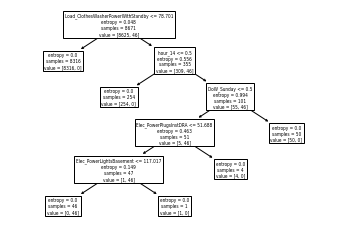

In [183]:
tree.plot_tree(clf, feature_names=feature_names)
plt.savefig("TreeClothes.eps", format='eps', bbox_inches = "tight")
plt.show()

In [184]:
from sklearn.metrics import accuracy_score
accuracy_score(clf.predict(X_rf), y_rf)

1.0